In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [5]:
# Load the data
data = pd.read_csv('747.csv')  # Replace with '747.csv' or your actual file

# Define the time range (replace with your actual peak values)
start_time = 34.2316  # Start time in minutes
end_time = 38.6007 # End time in minutes

# Filter data between start_time and end_time
filtered_data = data[(data['time (min)'] >= start_time) & (data['time (min)'] <= end_time)]

# Extract time and Detector 16 voltage
time = filtered_data['time (min)'].values  # Time in minutes
detector_16_voltage = filtered_data['raw light scattering data: detector voltage  (V) detector 16'].values

# Extract count rate data
count_rate = filtered_data['count rate: count rate  (Hz)'].values
count_rate_corr = filtered_data['count rate at corr. func.: count rate  (Hz)'].values

# Display basic information
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Time range: {time.min()} to {time.max()} minutes")

data.head()

Filtered data shape: (512, 24)
Time range: 34.240107 to 38.60065396 minutes


,time (min),raw light scattering data: detector voltage (V) detector 2,raw light scattering data: detector voltage (V) detector 3,raw light scattering data: detector voltage (V) detector 4,raw light scattering data: detector voltage (V) detector 5,raw light scattering data: detector voltage (V) detector 6,raw light scattering data: detector voltage (V) detector 7,raw light scattering data: detector voltage (V) detector 8,raw light scattering data: detector voltage (V) detector 9,raw light scattering data: detector voltage (V) detector 10,...,raw light scattering data: detector voltage (V) detector 15,raw light scattering data: detector voltage (V) detector 16,raw light scattering data: detector voltage (V) detector 17,raw light scattering data: detector voltage (V) detector 18,UV absorbance data: absorbance (AU) channel 1,UV absorbance data: absorbance (AU) channel 2,count rate: count rate (Hz),count rate at corr. func.: count rate (Hz),Forward Laser Monitor: Forward Laser Monitor (V),Auto-inject Signal: Auto-inject Signal
0,0.004267,0.116025,0.028934,0.014760,0.006790,0.015795,0.011698,0.010381,0.008974,0.008909,...,0.013398,0.017540,0.015734,0.020336,NaN,NaN,49247.46809,,0.930894,
1,0.012800,0.116024,0.028932,0.014762,0.006788,0.015794,0.011701,0.010378,0.008975,0.008908,...,0.013398,0.017538,0.015736,0.020340,-0.000015,0.000013,49307.54003,,0.930904,
2,0.021333,0.116034,0.028927,0.014768,0.006788,0.015791,0.011704,0.010375,0.008974,0.008910,...,0.013398,0.017537,0.015730,0.020344,-0.000016,0.000010,48985.66150,48992.5118100000,0.930920,
3,0.029867,0.116034,0.028930,0.014770,0.006790,0.015799,0.011708,0.010382,0.008979,0.008915,...,0.013408,0.017544,0.015728,0.020348,-0.000016,0.000009,47835.78403,48976.7657300000,0.930926,
4,0.038400,0.116044,0.028938,0.014768,0.006795,0.015808,0.011705,0.010379,0.008976,0.008916,...,0.013404,0.017544,0.015722,0.020353,-0.000016,0.000009,48948.79950,48961.0196400000,0.930933,


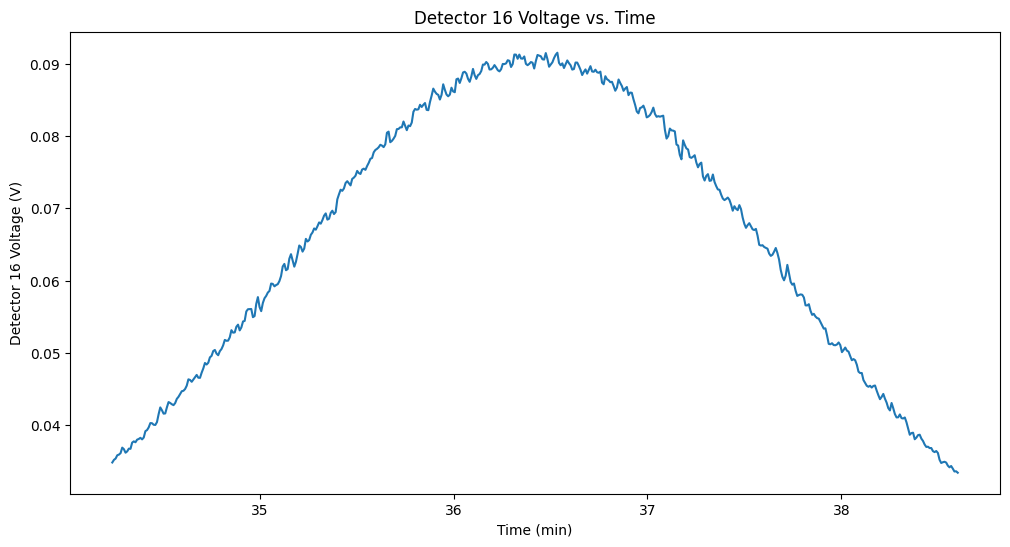

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(time, detector_16_voltage)
plt.xlabel('Time (min)')
plt.ylabel('Detector 16 Voltage (V)')
plt.title('Detector 16 Voltage vs. Time')
plt.show()

In [4]:
# Allow user to select a time slice
selected_time = float(input('Enter the time (min) at which you want to analyze the data: '))

# Find the index closest to the selected time
selected_index = np.argmin(np.abs(time - selected_time))
selected_time_actual = time[selected_index]

print(f"Selected time: {selected_time_actual:.4f} min")


Selected time: 34.2401 min


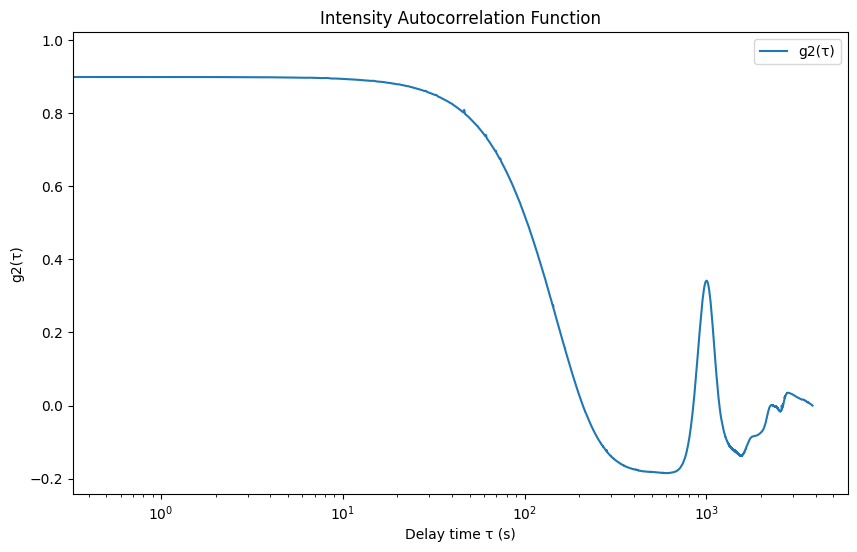

TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1

In [12]:
import numpy as np
import pandas as pd

# Load your data
data = pd.read_csv('747.csv')

# Extract the relevant columns
time = data['time (min)'] * 60  # Convert time to seconds
intensity = data['count rate: count rate  (Hz)']  # Example detector

# Define the time range for the peak
t1 = 34.2316  # Start time (s)
t2 = 38.6007  # End time (s)

# Filter the time and intensity data within the specified time range
time_peak = time[(time >= t1) & (time <= t2)]
intensity_peak = intensity[(time >= t1) & (time <= t2)]


I_mean = np.mean(intensity)
I_fluct = intensity - I_mean
# Compute the full autocorrelation
autocorr = np.correlate(I_fluct, I_fluct, mode='full')

# Take the second half of the autocorrelation result
autocorr = autocorr[autocorr.size // 2:]

# Normalize to get g2(τ)
g2_tau = autocorr / (I_mean**2 * len(intensity))
# Calculate the time intervals between measurements
dt = np.mean(np.diff(time))  # Assuming constant sampling rate
tau = np.arange(len(g2_tau)) * dt  # Delay times
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogx(tau, g2_tau, label='g2(τ)')
plt.xlabel('Delay time τ (s)')
plt.ylabel('g2(τ)')
plt.title('Intensity Autocorrelation Function')
plt.legend()
plt.show()

# Define the min and max delay times for fitting
min_tau = 2e-7  # Minimum delay time (s)
max_tau = 1e0   # Maximum delay time (s)

# Filter the tau and g2_tau for fitting
fit_indices = (tau >= min_tau) & (tau <= max_tau)
tau_fit = tau[fit_indices]
g2_tau_fit = g2_tau[fit_indices]

from scipy.optimize import curve_fit

# Define the model for g2(τ) function
def g2_model(tau, B, beta, Gamma):
    return B + beta * np.exp(-2 * Gamma * tau)

# Initial guesses for the fitting parameters
B_initial = 1.0  # Baseline at infinite delay
beta_initial = g2_tau_fit[0] - B_initial  # Amplitude at zero delay
Gamma_initial = 1.0  # Initial decay rate

p0 = [B_initial, beta_initial, Gamma_initial]

# Perform nonlinear least squares fitting
popt, pcov = curve_fit(g2_model, tau_fit, g2_tau_fit, p0=p0)

# Extract fitted parameters
B_fit, beta_fit, Gamma_fit = popt

print(f'Fitted parameters within delay time range [{min_tau}, {max_tau}] seconds:')
print(f'B = {B_fit}')
print(f'beta = {beta_fit}')
print(f'Gamma = {Gamma_fit}')
# Generate the fitted g2(τ) values
g2_fit = g2_model(tau, *popt)

plt.figure(figsize=(10, 6))
plt.semilogx(tau, g2_tau, 'b.', label='Data')
plt.semilogx(tau_fit, g2_model(tau_fit, *popt), 'r-', label='Fit (within range)')
plt.xlabel('Delay time τ (s)')
plt.ylabel('g2(τ)')
plt.title('Intensity Autocorrelation Function with Fit')
plt.legend()
plt.show()


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load your data
data = pd.read_csv('747.csv')

# Extract the relevant columns
time = data['time (min)'] * 60  # Convert time to seconds
intensity = data['raw light scattering data: detector voltage  (V) detector 16']  # Example detector

# Step 1: Filter the Data for the Specified Time Period
t1 = 34.2316 * 60 # Start time (s)
t2 = 38.6007  * 60 # End time (s)

# Filter the time and intensity data within the specified time range
time_peak = time[(time >= t1) & (time <= t2)]
intensity_peak = intensity[(time >= t1) & (time <= t2)]

# Step 2: Calculate the Intensity Fluctuations
I_mean = np.mean(intensity_peak)
I_fluct = intensity_peak - I_mean

# Step 3: Compute the Autocorrelation Function
autocorr = np.correlate(I_fluct, I_fluct, mode='full')
autocorr = autocorr[autocorr.size // 2:]

# Normalize to get g2(τ)
g2_tau = autocorr / (I_mean**2 * len(intensity_peak))

# Step 4: Define the Delay Times (τ) and Filter Them
dt = np.mean(np.diff(time_peak))  # Assuming constant sampling rate
tau = np.arange(len(g2_tau)) * dt  # Delay times

# Define the min and max delay times for fitting
min_tau = 2e-7  # Minimum delay time (s)
max_tau = 1e0   # Maximum delay time (s)

# Filter the tau and g2_tau for fitting within the desired delay time range
fit_indices = (tau >= min_tau) & (tau <= max_tau)
tau_fit = tau[fit_indices]
g2_tau_fit = g2_tau[fit_indices]

# Check the number of points for fitting
print(f'Number of points in tau_fit: {len(tau_fit)}')
print(f'Number of points in g2_tau_fit: {len(g2_tau_fit)}')

# Step 5: Fit the g2(τ) Function if Enough Points
if len(tau_fit) > 3:  # Ensure there are more data points than parameters
    def g2_model(tau, B, beta, Gamma):
        return B + beta * np.exp(-2 * Gamma * tau)

    # Initial guesses for the fitting parameters
    B_initial = 1.0  # Baseline at infinite delay
    beta_initial = g2_tau_fit[0] - B_initial  # Amplitude at zero delay
    Gamma_initial = 1.0  # Initial decay rate

    p0 = [B_initial, beta_initial, Gamma_initial]

    popt, pcov = curve_fit(g2_model, tau_fit, g2_tau_fit, p0=p0)
    
    # Extract fitted parameters
    B_fit, beta_fit, Gamma_fit = popt

    print(f'Fitted parameters within delay time range [{min_tau}, {max_tau}] seconds:')
    print(f'B = {B_fit}')
    print(f'beta = {beta_fit}')
    print(f'Gamma = {Gamma_fit}')

    # Plot the fitted g2(τ) function
    g2_fit = g2_model(tau, *popt)

    plt.figure(figsize=(10, 6))
    plt.semilogx(tau, g2_tau, 'b.', label='Data')
    plt.semilogx(tau_fit, g2_model(tau_fit, *popt), 'r-', label='Fit (within range)')
    plt.xlabel('Delay time τ (s)')
    plt.ylabel('g2(τ)')
    plt.title('Intensity Autocorrelation Function with Fit')
    plt.legend()
    plt.show()
else:
    print("Not enough data points within the specified delay time range for fitting.")
    
data.head()


Number of points in tau_fit: 1
Number of points in g2_tau_fit: 1
Not enough data points within the specified delay time range for fitting.


,time (min),raw light scattering data: detector voltage (V) detector 2,raw light scattering data: detector voltage (V) detector 3,raw light scattering data: detector voltage (V) detector 4,raw light scattering data: detector voltage (V) detector 5,raw light scattering data: detector voltage (V) detector 6,raw light scattering data: detector voltage (V) detector 7,raw light scattering data: detector voltage (V) detector 8,raw light scattering data: detector voltage (V) detector 9,raw light scattering data: detector voltage (V) detector 10,...,raw light scattering data: detector voltage (V) detector 15,raw light scattering data: detector voltage (V) detector 16,raw light scattering data: detector voltage (V) detector 17,raw light scattering data: detector voltage (V) detector 18,UV absorbance data: absorbance (AU) channel 1,UV absorbance data: absorbance (AU) channel 2,count rate: count rate (Hz),count rate at corr. func.: count rate (Hz),Forward Laser Monitor: Forward Laser Monitor (V),Auto-inject Signal: Auto-inject Signal
0,0.004267,0.116025,0.028934,0.014760,0.006790,0.015795,0.011698,0.010381,0.008974,0.008909,...,0.013398,0.017540,0.015734,0.020336,NaN,NaN,49247.46809,,0.930894,
1,0.012800,0.116024,0.028932,0.014762,0.006788,0.015794,0.011701,0.010378,0.008975,0.008908,...,0.013398,0.017538,0.015736,0.020340,-0.000015,0.000013,49307.54003,,0.930904,
2,0.021333,0.116034,0.028927,0.014768,0.006788,0.015791,0.011704,0.010375,0.008974,0.008910,...,0.013398,0.017537,0.015730,0.020344,-0.000016,0.000010,48985.66150,48992.5118100000,0.930920,
3,0.029867,0.116034,0.028930,0.014770,0.006790,0.015799,0.011708,0.010382,0.008979,0.008915,...,0.013408,0.017544,0.015728,0.020348,-0.000016,0.000009,47835.78403,48976.7657300000,0.930926,
4,0.038400,0.116044,0.028938,0.014768,0.006795,0.015808,0.011705,0.010379,0.008976,0.008916,...,0.013404,0.017544,0.015722,0.020353,-0.000016,0.000009,48948.79950,48961.0196400000,0.930933,


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data from the provided CSV file
data = pd.read_csv('747.csv')

# Extract the relevant columns
time = data['time (min)'] * 60  # Convert time to seconds
intensity = data['raw light scattering data: detector voltage  (V) detector 16']  # Example detector

# Step 1: Filter the Data for the Specified Time Period
t1 = 34.2316 * 60 # Start time (s)
t2 = 38.6007  * 60# End time (s)

# Filter the time and intensity data within the specified time range
time_peak = time[(time >= t1) & (time <= t2)]
intensity_peak = intensity[(time >= t1) & (time <= t2)]

# Step 2: Calculate the Intensity Fluctuations
I_mean = np.mean(intensity_peak)
I_fluct = intensity_peak - I_mean

# Step 3: Compute the Autocorrelation Function
autocorr = np.correlate(I_fluct, I_fluct, mode='full')
autocorr = autocorr[autocorr.size // 2:]

# Normalize to get g2(τ)
g2_tau = autocorr / (I_mean**2 * len(intensity_peak))

# Step 4: Define the Delay Times (τ) and Filter Them
dt = np.mean(np.diff(time_peak))  # Calculate the time difference (assuming constant sampling rate)
tau = np.arange(len(g2_tau)) * dt  # Generate delay times

# Now, print the tau values and g2_tau values for debugging
print(f"tau values: {tau}")
print(f"g2_tau values: {g2_tau}")

# Define the min and max delay times for fitting
min_tau = 2e-7  # Minimum delay time (s)
max_tau = 1e0   # Maximum delay time (s)

# Filter the tau and g2_tau for fitting within the desired delay time range
fit_indices = (tau >= min_tau) & (tau <= max_tau)
tau_fit = tau[fit_indices]
g2_tau_fit = g2_tau[fit_indices]

# Now, print the filtered tau and g2_tau for debugging
print(f"Filtered tau_fit values: {tau_fit}")
print(f"Filtered g2_tau_fit values: {g2_tau_fit}")

# Check the number of points for fitting
print(f'Number of points in tau_fit: {len(tau_fit)}')
print(f'Number of points in g2_tau_fit: {len(g2_tau_fit)}')

# Step 5: Fit the g2(τ) Function if Enough Points
if len(tau_fit) > 3:  # Ensure there are more data points than parameters
    def g2_model(tau, B, beta, Gamma):
        return B + beta * np.exp(-2 * Gamma * tau)

    # Initial guesses for the fitting parameters
    B_initial = 1.0  # Baseline at infinite delay
    beta_initial = g2_tau_fit[0] - B_initial  # Amplitude at zero delay
    Gamma_initial = 1.0  # Initial decay rate

    p0 = [B_initial, beta_initial, Gamma_initial]

    popt, pcov = curve_fit(g2_model, tau_fit, g2_tau_fit, p0=p0)
    
    # Extract fitted parameters
    B_fit, beta_fit, Gamma_fit = popt

    print(f'Fitted parameters within delay time range [{min_tau}, {max_tau}] seconds:')
    print(f'B = {B_fit}')
    print(f'beta = {beta_fit}')
    print(f'Gamma = {Gamma_fit}')

    # Plot the fitted g2(τ) function
    g2_fit = g2_model(tau, *popt)

    plt.figure(figsize=(10, 6))
    plt.semilogx(tau, g2_tau, 'b.', label='Data')
    plt.semilogx(tau_fit, g2_model(tau_fit, *popt), 'r-', label='Fit (within range)')
    plt.xlabel('Delay time τ (s)')
    plt.ylabel('g2(τ)')
    plt.title('Intensity Autocorrelation Function with Fit')
    plt.legend()
    plt.show()
else:
    print("Not enough data points within the specified delay time range for fitting.")


tau values: [  0.          0.5120016   1.0240032   1.5360048   2.0480064   2.560008
   3.0720096   3.5840112   4.0960128   4.6080144   5.120016    5.6320176
   6.1440192   6.6560208   7.1680224   7.680024    8.1920256   8.7040272
   9.2160288   9.7280304  10.240032   10.7520336  11.2640352  11.7760368
  12.2880384  12.80004    13.3120416  13.8240432  14.3360448  14.8480464
  15.360048   15.8720496  16.3840512  16.8960528  17.4080544  17.920056
  18.4320576  18.9440592  19.4560608  19.9680624  20.480064   20.9920656
  21.5040672  22.0160688  22.5280704  23.040072   23.5520736  24.0640752
  24.5760768  25.0880784  25.60008    26.1120816  26.6240832  27.1360848
  27.6480864  28.160088   28.6720896  29.1840912  29.6960928  30.2080944
  30.720096   31.2320976  31.7440992  32.2561008  32.7681024  33.280104
  33.7921056  34.3041072  34.8161088  35.3281104  35.840112   36.3521136
  36.8641152  37.3761168  37.8881184  38.40012    38.9121216  39.4241232
  39.9361248  40.4481264  40.960128   41.4

tau values: [0.        0.5120016 1.0240032 1.5360048 2.0480064 2.560008  3.0720096
 3.5840112]
g2_tau values: [ 6.90307638e-08  3.65023657e-08 -6.98501438e-09 -2.14226018e-08
 -2.46395801e-08 -1.91469563e-08 -2.40010723e-09  3.57651222e-09]
Filtered tau_fit values: [0.5120016 1.0240032 1.5360048 2.0480064 2.560008  3.0720096 3.5840112]
Filtered g2_tau_fit values: [ 3.65023657e-08 -6.98501438e-09 -2.14226018e-08 -2.46395801e-08
 -1.91469563e-08 -2.40010723e-09  3.57651222e-09]
Number of points in tau_fit: 7
Number of points in g2_tau_fit: 7
Fitted parameters within delay time range [1e-07, 100.0] seconds:
B = -1.254981861940782e-08
beta = 6.22072662338843e-07
Gamma = 2.479242554978511


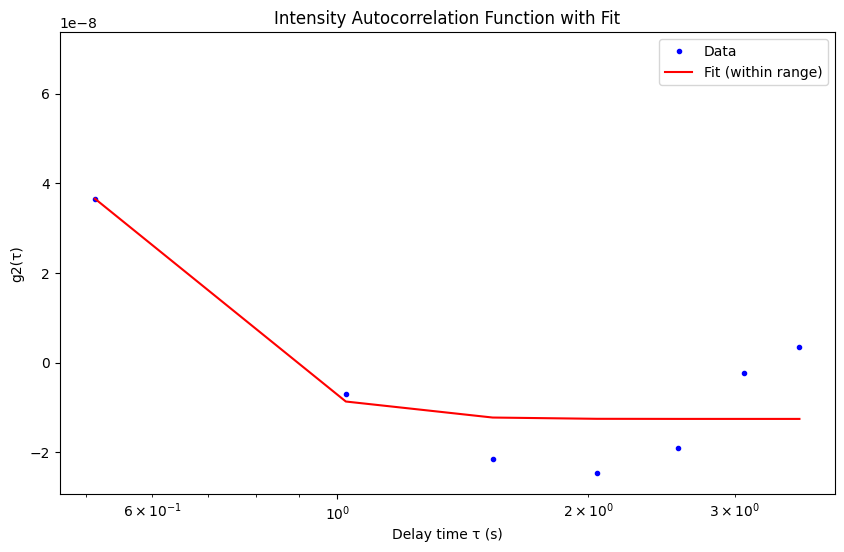

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data from the provided CSV file
data = pd.read_csv('747.csv')

# Extract the relevant columns
time = data['time (min)'] * 60  # Convert time to seconds
intensity = data['raw light scattering data: detector voltage  (V) detector 16']  # Example detector

# Step 1: Filter the Data for the Specified Time Period
t1 = 34.2316 #*60  # Start time (s)
t2 = 38.6007 #*60 # End time (s)

# Filter the time and intensity data within the specified time range
time_peak = time[(time >= t1) & (time <= t2)]
intensity_peak = intensity[(time >= t1) & (time <= t2)]

# Step 2: Calculate the Intensity Fluctuations
I_mean = np.mean(intensity_peak)
I_fluct = intensity_peak - I_mean

# Step 3: Compute the Autocorrelation Function
autocorr = np.correlate(I_fluct, I_fluct, mode='full')
autocorr = autocorr[autocorr.size // 2:]

# Normalize to get g2(τ)
g2_tau = autocorr / (I_mean**2 * len(intensity_peak))

# Step 4: Define the Delay Times (τ) and Filter Them
dt = np.mean(np.diff(time_peak))  # Calculate the time difference (assuming constant sampling rate)
tau = np.arange(len(g2_tau)) * dt  # Generate delay times

# Now, print the tau values and g2_tau values for debugging
print(f"tau values: {tau}")
print(f"g2_tau values: {g2_tau}")

# Adjusted min and max delay times for fitting
min_tau = 1e-7  # Adjusted minimum delay time (s)
max_tau = 1e2  # Maximum delay time (s)

# Filter the tau and g2_tau for fitting within the desired delay time range
fit_indices = (tau >= min_tau) & (tau <= max_tau)
tau_fit = tau[fit_indices]
g2_tau_fit = g2_tau[fit_indices]

# Now, print the filtered tau and g2_tau for debugging
print(f"Filtered tau_fit values: {tau_fit}")
print(f"Filtered g2_tau_fit values: {g2_tau_fit}")

# Check the number of points for fitting
print(f'Number of points in tau_fit: {len(tau_fit)}')
print(f'Number of points in g2_tau_fit: {len(g2_tau_fit)}')

# Step 5: Fit the g2(τ) Function if Enough Points
if len(tau_fit) > 3:  # Ensure there are more data points than parameters
    def g2_model(tau, B, beta, Gamma):
        return B + beta * np.exp(-2 * Gamma * tau)

    # Initial guesses for the fitting parameters
    B_initial = 1.0  # Baseline at infinite delay
    beta_initial = g2_tau_fit[0] - B_initial  # Amplitude at zero delay
    Gamma_initial = 1.0  # Initial decay rate

    p0 = [B_initial, beta_initial, Gamma_initial]

    popt, pcov = curve_fit(g2_model, tau_fit, g2_tau_fit, p0=p0)
    
    # Extract fitted parameters
    B_fit, beta_fit, Gamma_fit = popt

    print(f'Fitted parameters within delay time range [{min_tau}, {max_tau}] seconds:')
    print(f'B = {B_fit}')
    print(f'beta = {beta_fit}')
    print(f'Gamma = {Gamma_fit}')

    # Plot the fitted g2(τ) function
    g2_fit = g2_model(tau, *popt)

    plt.figure(figsize=(10, 6))
    plt.semilogx(tau, g2_tau, 'b.', label='Data')
    plt.semilogx(tau_fit, g2_model(tau_fit, *popt), 'r-', label='Fit (within range)')
    plt.xlabel('Delay time τ (s)')
    plt.ylabel('g2(τ)')
    plt.title('Intensity Autocorrelation Function with Fit')
    plt.legend()
    plt.show()
else:
    print("Not enough data points within the specified delay time range for fitting.")


Hydrodynamic Radius (Rh): 4.44e-17 m


C:\Users\User\AppData\Local\Temp\ipykernel_9004\3658182911.py:25: RuntimeWarning: overflow encountered in exp
  return np.exp(-2 * D * tau)


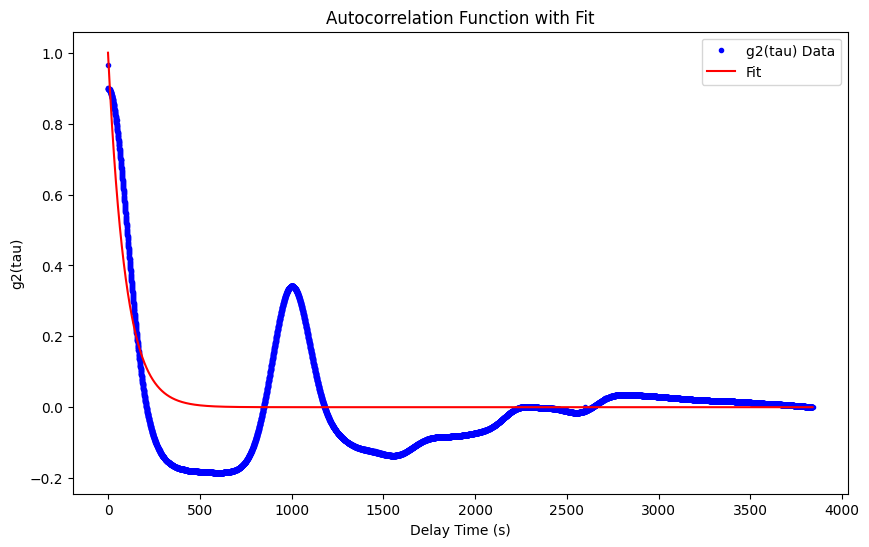

In [29]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('747.csv')

# Extract the relevant columns for count rate and correlation function
count_rate = df['count rate: count rate  (Hz)'].values

# Step 1: Calculate the intensity fluctuations from count rate
I_mean = np.mean(count_rate)
I_fluct = count_rate - I_mean

# Step 2: Compute the autocorrelation function of the intensity fluctuations
autocorr = np.correlate(I_fluct, I_fluct, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Keep only the second half

# Normalize the autocorrelation function to get g2(tau)
g2_tau = autocorr / (I_mean**2 * len(count_rate))

# Step 3: Define the exponential decay model for fitting g2(tau)
def exp_decay(tau, D):
    return np.exp(-2 * D * tau)

# Generate tau values (time delay, assumed evenly spaced by the count rate sampling)
dt = np.mean(np.diff(df['time (min)'].values)) * 60  # Convert minutes to seconds
tau = np.arange(len(g2_tau)) * dt  # Delay times

# Fit the exponential decay model to g2(tau)
popt, _ = curve_fit(exp_decay, tau, g2_tau)
D = popt[0]  # Extract the diffusion coefficient from the fit

# Step 4: Calculate the hydrodynamic radius (Rh) using the Stokes-Einstein equation
k_B = 1.380649e-23  # Boltzmann constant in J/K
T = 273.15 + 23     # Temperature in Kelvin (assuming 23°C)
eta = 0.9324017768e-3  # Viscosity in Pa·s (from the XML report)

# Calculate Rh
Rh = k_B * T / (6 * np.pi * eta * D)
print(f"Hydrodynamic Radius (Rh): {Rh:.2e} m")

# Optional: Plot the autocorrelation function and the fitted curve
g2_fit = exp_decay(tau, D)
plt.figure(figsize=(10, 6))
plt.plot(tau, g2_tau, 'b.', label='g2(tau) Data')
plt.plot(tau, g2_fit, 'r-', label='Fit')
plt.xlabel('Delay Time (s)')
plt.ylabel('g2(tau)')
plt.title('Autocorrelation Function with Fit')
plt.legend()
plt.show()
